In [1]:
import copick
import pandas as pd
import zarr
from matplotlib import pyplot as plt
import os
import json
import numpy as np
from keras import layers, models
from keras.api.losses import BinaryCrossentropy
from keras.api.callbacks import ModelCheckpoint,TensorBoard,EarlyStopping
from tqdm import tqdm
from numba import njit, prange
import datetime

In [2]:
def get_copick_root(split):
    """
    Loads the copick configuration based on the split.

    Args:
        split (str): 'train' or 'test'.

    Returns:
        copick_root: The loaded copick configuration.
    """
    config_path = '../../copick_config.json' if split == 'train' else '../../copick_config_test.json'
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Configuration file not found: {config_path}")
    copick_root = copick.from_file(config_path)
    return copick_root



In [3]:
def get_static_tomogram(run_name, split='train', tomo_type='denoised', zarr_group_idx=0):
    """
    Retrieves a static tomogram from the copick dataset.

    Args:
        run_name (str): Name of the run.
        split (str): 'train' or 'test'.
        tomo_type (str): Type of tomogram.
        zarr_group_idx (int): Index of the Zarr group.

    Returns:
        np.ndarray: The tomogram data as a NumPy array.
    """
    copick_root = get_copick_root(split)
    run = copick_root.get_run(run_name)
    voxel_spacing = run.get_voxel_spacing(10.000)
    tomogram = voxel_spacing.get_tomogram(tomo_type)
    zarr_store = tomogram.zarr()
    zarr_group = zarr.open(zarr_store, mode='r')
    try:
        tomogram_vals = zarr_group[str(zarr_group_idx)][:]  # Use string keys if necessary
    except KeyError:
        raise KeyError(f"Zarr group index {zarr_group_idx} not found in the store.")
    return tomogram_vals



In [4]:
def get_label_locations(run_name, copick_root, voxel_spacing=10):
    """
    Extracts label locations from JSON files for a given run.

    Args:
        run_name (str): Name of the run.
        copick_root: Copick root object.
        voxel_spacing (float): Voxel spacing for normalization.

    Returns:
        dict: Dictionary with particle names as keys and arrays of locations as values.
    """
    picks_folder = os.path.join(copick_root.config.overlay_root, 'ExperimentRuns', run_name, 'Picks')
    if not os.path.exists(picks_folder):
        raise FileNotFoundError(f"Picks folder not found: {picks_folder}")

    picks = {}
    for json_file in os.listdir(picks_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(picks_folder, json_file)
            with open(json_path, 'r') as file:
                pick_data = json.load(file)
            particle_name = json_file[:-5]  # Remove '.json' extension
            picks[particle_name] = np.array([
                [
                    point['location']['x'] / voxel_spacing,
                    point['location']['y'] / voxel_spacing,
                    point['location']['z'] / voxel_spacing
                ]
                for point in pick_data.get('points', [])
            ])
    return picks



In [5]:
@njit(parallel=True)
def add_gaussian_to_heatmap_max(heatmap, z, y, x, kernel, half_size, depth, height, width):
    """
    Adds a Gaussian kernel to the heatmap at the specified (z, y, x) location using maximum.
    """
    for i in prange(kernel.shape[0]):
        for j in range(kernel.shape[1]):
            for k in range(kernel.shape[2]):
                zi = z + i - half_size
                yi = y + j - half_size
                xi = x + k - half_size
                if 0 <= zi < depth and 0 <= yi < height and 0 <= xi < width:
                    if kernel[i, j, k] > heatmap[zi, yi, xi]:
                        heatmap[zi, yi, xi] = kernel[i, j, k]



In [6]:
def generate_heatmaps_optimized_max(df, tomogram_shape, particle_types):
    """
    Optimized function to generate 3D heatmaps for particle locations with maximum Gaussian spread.
    """
    depth, height, width = tomogram_shape
    num_classes = len(particle_types)
    heatmaps = np.zeros((depth, height, width, num_classes), dtype=np.float32)

    # Map particle types to channels
    particle_to_channel = {particle: i for i, particle in enumerate(particle_types)}

    # Group by 'particle' and 'radius'
    grouped = df.groupby(['particle', 'radius'])

    # Precompute Gaussian kernels for each group with adjusted sigma
    kernels = {}
    for (particle, radius), group in grouped:
        # Adjust sigma to ensure rapid decay within radius
        sigma = radius  # You may adjust this to radius / 3 for faster decay
        if sigma == 0:
            # Handle cases where radius is zero to avoid division by zero
            kernel = np.zeros((1, 1, 1), dtype=np.float32)
            kernel[0, 0, 0] = 1.0
            kernels[(particle, radius)] = (kernel, 0)
            continue

        # Define the size of the kernel; typically 6*sigma to capture the Gaussian effectively
        kernel_size = int(6 * sigma) + 1  # Ensure kernel size is odd
        half_size = kernel_size // 2
        x = np.arange(-half_size, half_size + 1)
        y = np.arange(-half_size, half_size + 1)
        z_axis = np.arange(-half_size, half_size + 1)
        zz, yy_grid, xx = np.meshgrid(z_axis, y, x, indexing='ij')
        kernel = np.exp(-(xx ** 2 + yy_grid ** 2 + zz ** 2) / (2 * sigma ** 2))
        kernel /= kernel.max()  # Normalize the kernel peak to 1
        kernels[(particle, radius)] = (kernel.astype(np.float32), half_size)

    # Iterate over groups and add Gaussian kernels to the heatmaps
    for (particle, radius), (kernel, half_size) in tqdm(kernels.items(), desc="Generating Heatmaps"):
        channel = particle_to_channel[particle]
        # Extract all particles in the current group
        mask = (df['particle'] == particle) & (df['radius'] == radius)
        particles = df[mask][['z', 'y', 'x']].to_numpy().astype(np.int32)  # Order: z, y, x

        # Add Gaussian kernels to the heatmap using maximum
        for z, y, x in particles:
            add_gaussian_to_heatmap_max(
                heatmaps[..., channel],
                z, y, x,
                kernel, half_size,
                depth, height, width
            )

    return heatmaps



In [7]:
def overlay_heatmaps_on_tomogram(tomogram_slice, heatmaps_slice, particle_types, threshold=0.3):
    """
    Overlays colored heatmaps onto a tomogram slice.

    Args:
        tomogram_slice (np.ndarray): 2D tomogram slice.
        heatmaps_slice (np.ndarray): 3D heatmap slice (height, width, num_classes).
        particle_types (list): List of particle types.
        threshold (float): Intensity threshold for heatmap visibility.

    Returns:
        None: Displays the overlay plot.
    """
    # Normalize tomogram slice to [0, 1]
    tomogram_normalized = (tomogram_slice - tomogram_slice.min()) / (tomogram_slice.max() - tomogram_slice.min())
    tomogram_rgb = np.stack([tomogram_normalized] * 3, axis=-1)  # Convert grayscale to RGB

    # Generate distinct colors for each particle type
    cmap = plt.cm.get_cmap('tab10', len(particle_types))
    particle_colors = [cmap(i)[:3] for i in range(len(particle_types))]

    # Initialize an RGB array for the heatmap overlay
    overlay = np.zeros_like(tomogram_rgb, dtype=np.float32)

    for i, particle_color in enumerate(particle_colors):
        heatmap = heatmaps_slice[..., i]
        mask = heatmap > threshold
        for c in range(3):
            overlay[..., c] += particle_color[c] * mask.astype(np.float32)

    # Combine the tomogram with the overlay
    combined = tomogram_rgb + overlay
    combined = np.clip(combined, 0, 1)

    plt.figure(figsize=(10, 8))
    plt.imshow(combined, interpolation='nearest')
    plt.axis('off')
    plt.title('Tomogram Slice with Heatmap Overlay')
    plt.show()



In [8]:
# Load copick configurations
copick_root_train = get_copick_root('train')
copick_root_test = get_copick_root('test')


In [9]:
# Retrieve run names
training_runs = copick_root_train.runs
testing_runs = copick_root_test.runs

training_run_names = [run.name for run in training_runs]
testing_run_names = [run.name for run in testing_runs]
extra_training_run_names = list(set(training_run_names) - set(testing_run_names))

print(f'Training runs: {training_run_names}')
print(f'Testing runs: {testing_run_names}')
print(f'Extra training runs not in testing: {extra_training_run_names}')


Training runs: ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']
Testing runs: ['TS_5_4', 'TS_69_2', 'TS_6_4']
Extra training runs not in testing: ['TS_99_9', 'TS_73_6', 'TS_86_3', 'TS_6_6']


In [10]:
# Load tomograms
tomograms_train = []
tomograms_test = []

for training_run_name in training_run_names:
    try:
        tomo = get_static_tomogram(split='train', run_name=training_run_name)
        tomograms_train.append({'run': training_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {training_run_name}: {e}")

for testing_run_name in testing_run_names:
    try:
        tomo = get_static_tomogram(split='test', run_name=testing_run_name)
        tomograms_test.append({'run': testing_run_name, 'tomogram': tomo})
    except Exception as e:
        print(f"Error loading tomogram for run {testing_run_name}: {e}")

print(f'Number of train tomograms: {len(tomograms_train)}')
print(f'Number of test tomograms: {len(tomograms_test)}')


Number of train tomograms: 7
Number of test tomograms: 3


In [11]:
# Verify the loaded tomograms
if tomograms_train:
    sample_tomo = tomograms_train[0]['tomogram']
    print(f"Type: {type(sample_tomo)}")
    print(f"Element Type: {type(sample_tomo[0])}")
    print(f"Shape: {sample_tomo.shape}")
else:
    print("No training tomograms loaded.")


Type: <class 'numpy.ndarray'>
Element Type: <class 'numpy.ndarray'>
Shape: (184, 630, 630)


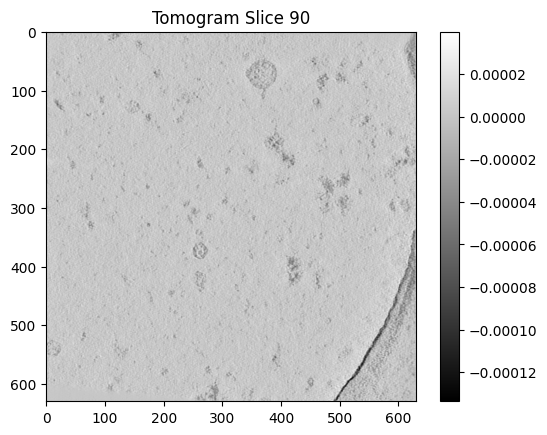

In [12]:
# Visualize a slice
if tomograms_train:
    slice_index = 90  # Adjust as needed
    if slice_index < tomograms_train[0]['tomogram'].shape[0]:
        plt.imshow(tomograms_train[0]['tomogram'][slice_index], cmap='gray')
        plt.title(f"Tomogram Slice {slice_index}")
        plt.colorbar()
        plt.show()
    else:
        print(
            f"Slice index {slice_index} out of range for tomogram with depth {tomograms_train[0]['tomogram'].shape[0]}")
else:
    print("No training tomograms to visualize.")


In [13]:
# Create DataFrame with particle locations
rows = []
for run in training_run_names:
    try:
        label_data = get_label_locations(run, copick_root_train)
        for particle, locations in label_data.items():
            matching_particles = [obj.radius for obj in copick_root_train.config.pickable_objects if
                                  obj.name == particle]
            if not matching_particles:
                print(f"No matching particle found for {particle} in run {run}")
                continue
            radius = matching_particles[0] / 10
            for location in locations:
                rows.append({
                    'run': run,
                    'particle': particle,
                    'x': location[0],
                    'y': location[1],
                    'z': location[2],
                    'radius': radius
                })
    except Exception as e:
        print(f"Error processing labels for run {run}: {e}")

particle_locations_df = pd.DataFrame(rows)
print(particle_locations_df.sample(5))
print(f"Total labeled particles: {len(particle_locations_df)}")


          run             particle         x         y         z  radius
1180  TS_99_9         beta-amylase  144.0667  100.1667   79.0333     6.5
927   TS_86_3   beta-galactosidase  130.4049  296.4441  118.0928     9.0
669   TS_73_6  virus-like-particle  616.1707  265.1433   46.5402    13.5
563    TS_6_6         apo-ferritin  567.1396  275.3784   79.7838     6.0
1170  TS_99_9         beta-amylase  188.5833   23.6667   18.4167     6.5
Total labeled particles: 1269


In [14]:
# Define particle types and tomogram shape
particle_types = sorted(particle_locations_df['particle'].unique())
if tomograms_train:
    tomogram_shape = tomograms_train[0]['tomogram'].shape
    print(f"Tomogram shape: {tomogram_shape}")
else:
    raise ValueError("No training tomograms available to determine shape.")


Tomogram shape: (184, 630, 630)


In [84]:
# Select a small 3D region for training and validation
# Define the region coordinates (adjust these based on your data)
train_z_start, train_z_end = 50, 150
train_y_start, train_y_end = 250, 350
train_x_start, train_x_end = 250, 350

val_z_start, val_z_end = 50, 150
val_y_start, val_y_end = 150, 250
val_x_start, val_x_end = 150, 250

# Extract the regions from the first tomogram
trainer_tom = tomograms_train[0]['tomogram'][train_z_start:train_z_end, train_y_start:train_y_end,
              train_x_start:train_x_end]
validator_tom = tomograms_train[0]['tomogram'][val_z_start:val_z_end, val_y_start:val_y_end, val_x_start:val_x_end]

print(f"Training region shape: {trainer_tom.shape}")
print(f"Validation region shape: {validator_tom.shape}")


Training region shape: (100, 100, 100)
Validation region shape: (100, 100, 100)


In [85]:
# Filter labels for the training region
trainer_labels = particle_locations_df[
    (particle_locations_df['z'] >= train_z_start) & (particle_locations_df['z'] < train_z_end) &
    (particle_locations_df['y'] >= train_y_start) & (particle_locations_df['y'] < train_y_end) &
    (particle_locations_df['x'] >= train_x_start) & (particle_locations_df['x'] < train_x_end)
    ].copy()

# Adjust label coordinates relative to the extracted region
trainer_labels['z'] = trainer_labels['z'] - train_z_start
trainer_labels['y'] = trainer_labels['y'] - train_y_start
trainer_labels['x'] = trainer_labels['x'] - train_x_start


In [86]:
# Filter labels for the validation region
validator_labels = particle_locations_df[
    (particle_locations_df['z'] >= val_z_start) & (particle_locations_df['z'] < val_z_end) &
    (particle_locations_df['y'] >= val_y_start) & (particle_locations_df['y'] < val_y_end) &
    (particle_locations_df['x'] >= val_x_start) & (particle_locations_df['x'] < val_x_end)
    ].copy()

# Adjust label coordinates relative to the extracted region
validator_labels['z'] = validator_labels['z'] - val_z_start
validator_labels['y'] = validator_labels['y'] - val_y_start
validator_labels['x'] = validator_labels['x'] - val_x_start

print(f"Number of training labels: {len(trainer_labels)}")
print(f"Number of validation labels: {len(validator_labels)}")


Number of training labels: 29
Number of validation labels: 23


In [87]:
# Generate heatmaps for the training region
if not trainer_labels.empty:
    trainer_heatmaps = generate_heatmaps_optimized_max(trainer_labels, trainer_tom.shape, particle_types)
else:
    trainer_heatmaps = np.zeros((trainer_tom.shape[0], trainer_tom.shape[1], trainer_tom.shape[2], len(particle_types)),
                                dtype=np.float32)

# Generate heatmaps for the validation region
if not validator_labels.empty:
    validator_heatmaps = generate_heatmaps_optimized_max(validator_labels, validator_tom.shape, particle_types)
else:
    validator_heatmaps = np.zeros(
        (validator_tom.shape[0], validator_tom.shape[1], validator_tom.shape[2], len(particle_types)), dtype=np.float32)


Generating Heatmaps: 100%|██████████| 6/6 [00:00<00:00, 598.57it/s]


In [88]:
# Prepare input and label data by adding a batch dimension
X_train = np.expand_dims(trainer_tom.astype(np.float32)[..., np.newaxis], axis=0)  # Shape: (1, 20, 30, 30, 1)
Y_train = np.expand_dims(trainer_heatmaps.astype(np.float32), axis=0)             # Shape: (1, 20, 30, 30, num_classes)

X_val = np.expand_dims(validator_tom.astype(np.float32)[..., np.newaxis], axis=0)  # Shape: (1, 20, 30, 30, 1)
Y_val = np.expand_dims(validator_heatmaps.astype(np.float32), axis=0)             # Shape: (1, 20, 30, 30, num_classes)

print(f"Training input shape: {X_train.shape}")
print(f"Training label shape: {Y_train.shape}")
print(f"Validation input shape: {X_val.shape}")
print(f"Validation label shape: {Y_val.shape}")



Training input shape: (1, 100, 100, 100, 1)
Training label shape: (1, 100, 100, 100, 6)
Validation input shape: (1, 100, 100, 100, 1)
Validation label shape: (1, 100, 100, 100, 6)


In [89]:
trainer_tom[...,np.newaxis].shape

(100, 100, 100, 1)

In [90]:
def calculate_output_dim(input_dim, pool_size, padding='same', strides=2):
    """
    Calculate the output dimension after a pooling or upsampling layer.
    
    Args:
        input_dim (int): Size of the dimension (depth, height, or width).
        pool_size (int): Pooling or upsampling factor.
        padding (str): 'same' or 'valid'.
        strides (int): Stride size.
    
    Returns:
        int: Output size after the operation.
    """
    if padding == 'same':
        return np.ceil(input_dim / strides)
    elif padding == 'valid':
        return np.floor((input_dim - pool_size) / strides) + 1
    else:
        raise ValueError("Padding must be 'same' or 'valid'")

def build_3d_cnn(input_shape, num_classes, target_shape):
    """
    Builds a 3D CNN model that matches target spatial dimensions.
    
    Args:
        input_shape (tuple): Shape of the input data (depth, height, width, channels).
        num_classes (int): Number of output classes.
        target_shape (tuple): Desired output spatial dimensions (depth, height, width).
    
    Returns:
        keras.Model: The constructed 3D CNN model.
    """
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)  # Downsample by 2
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)  # Downsample by 2

    # Decoder
    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling3D((2, 2, 2))(x)  # Upsample by 2
    x = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling3D((2, 2, 2))(x)  # Upsample by 2

    # Calculate expected output spatial dimensions
    input_depth, input_height, input_width = input_shape[:3]
    
    # After first MaxPooling3D
    depth_after_pool1 = calculate_output_dim(input_depth, pool_size=2, padding='same', strides=2)
    height_after_pool1 = calculate_output_dim(input_height, pool_size=2, padding='same', strides=2)
    width_after_pool1 = calculate_output_dim(input_width, pool_size=2, padding='same', strides=2)
    
    # After second MaxPooling3D
    depth_after_pool2 = calculate_output_dim(depth_after_pool1, pool_size=2, padding='same', strides=2)
    height_after_pool2 = calculate_output_dim(height_after_pool1, pool_size=2, padding='same', strides=2)
    width_after_pool2 = calculate_output_dim(width_after_pool1, pool_size=2, padding='same', strides=2)
    
    # After UpSampling3D (first upsampling)
    depth_after_up1 = depth_after_pool2 * 2
    height_after_up1 = height_after_pool2 * 2
    width_after_up1 = width_after_pool2 * 2
    
    # After UpSampling3D (second upsampling)
    depth_after_up2 = depth_after_up1 * 2
    height_after_up2 = height_after_up1 * 2
    width_after_up2 = width_after_up1 * 2

    # Expected output dimensions
    expected_depth = depth_after_up2
    expected_height = height_after_up2
    expected_width = width_after_up2

    # Compare with target_shape
    crop_depth = expected_depth - target_shape[0]
    crop_height = expected_height - target_shape[1]
    crop_width = expected_width - target_shape[2]

    # Calculate cropping sizes, ensuring non-negative
    crop_depth_before = max(crop_depth // 2, 0)
    crop_depth_after = max(crop_depth - crop_depth_before, 0)

    crop_height_before = max(crop_height // 2, 0)
    crop_height_after = max(crop_height - crop_height_before, 0)

    crop_width_before = max(crop_width // 2, 0)
    crop_width_after = max(crop_width - crop_width_before, 0)

    # Add Cropping3D layer if necessary
    if crop_depth > 0 or crop_height > 0 or crop_width > 0:
        x = layers.Cropping3D(
            cropping=((crop_depth_before, crop_depth_after),
                      (crop_height_before, crop_height_after),
                      (crop_width_before, crop_width_after))
        )(x)
        print(f"Cropping applied: Depth ({crop_depth_before}, {crop_depth_after}), "
              f"Height ({crop_height_before}, {crop_height_after}), "
              f"Width ({crop_width_before}, {crop_width_after})")
    else:
        print("No cropping needed.")

    # Output layer
    outputs = layers.Conv3D(num_classes, (1, 1, 1), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, outputs)
    return model

# Build the 3D CNN model with matching output dimensions
input_shape = X_train.shape[1:]  # (depth, height, width, channels)
output_shape = Y_train.shape[1:]
print(input_shape)
num_classes = len(particle_types)
model = build_3d_cnn(input_shape=input_shape, num_classes=num_classes,target_shape=output_shape)
model.summary()

(100, 100, 100, 1)
No cropping needed.


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 100, 100, 100,  │             0 │
│                                 │ 1)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_64 (Conv3D)              │ (None, 100, 100, 100,  │           448 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_26 (MaxPooling3D) │ (None, 50, 50, 50, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_65 (Conv3D)              │ (None, 50, 50, 50, 32) │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_27 (MaxPooling3D) │ (None, 25, 25, 25, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_66 (Conv3D)              │ (None, 25, 25, 25, 32) │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_23 (UpSampling3D) │ (None, 50, 50, 50, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_67 (Conv3D)              │ (None, 50, 50, 50, 16) │        13,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling3d_24 (UpSampling3D) │ (None, 100, 100, 100,  │             0 │
│                                 │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_68 (Conv3D)              │ (None, 100, 100, 100,  │           102 │
│                                 │ 6)                     │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,926 (218.46 KB)

 Trainable params: 55,926 (218.46 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
# Compile the model
loss = BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])


In [92]:
# Define callbacks
log_dir = f"./logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)


In [93]:
X_train.shape

(1, 100, 100, 100, 1)

In [97]:
# Train the model on the small section
epochs = 200G  # Set to a small number for testing
batch_size = 1  # Use batch_size=1 for minimal memory usage

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[tensorboard_callback, early_stopping, model_checkpoint]
)


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0773 - loss: 0.2870 - val_accuracy: 0.2427 - val_loss: 0.2120
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4255 - loss: 0.2772 - val_accuracy: 0.2700 - val_loss: 0.2084
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4973 - loss: 0.2711 - val_accuracy: 0.2653 - val_loss: 0.2114
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5009 - loss: 0.2673 - val_accuracy: 0.2653 - val_loss: 0.2205
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5009 - loss: 0.2671 - val_accuracy: 0.2653 - val_loss: 0.2370


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


/var/folders/dq/6g5fch396qb663c0xjt8xsxr0000gp/T/ipykernel_71454/1619561019.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(particle_types))


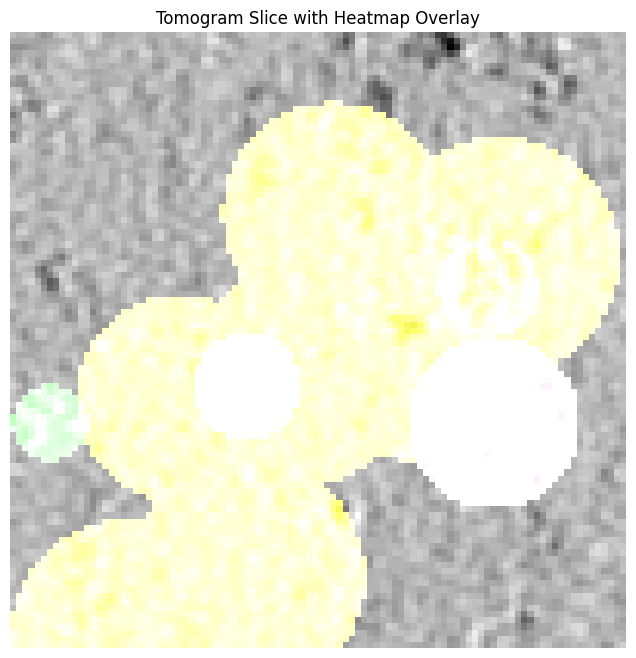

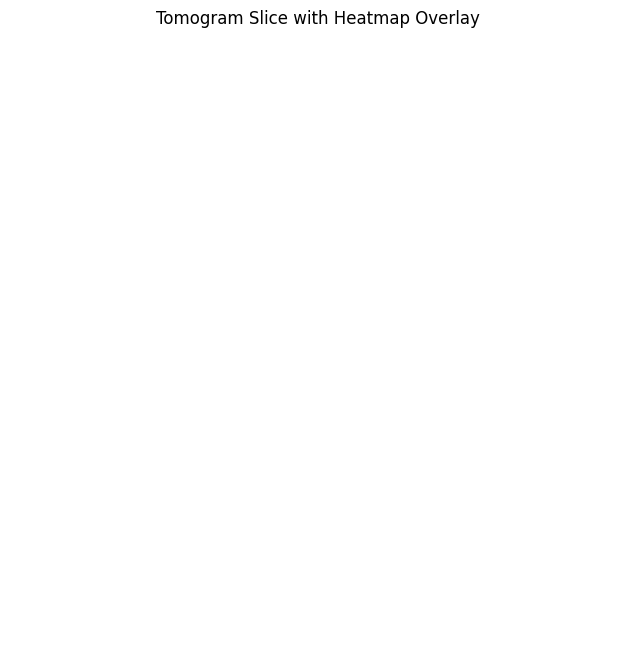

In [95]:
# Visualize a prediction on the validation data
# Make sure the validation data has at least one sample
if X_val.shape[0] > 0:
    # Select a sample from validation data
    sample_idx = 0
    tomogram_slice = X_val[sample_idx, :, :, :, 0]
    ground_truth_heatmap = Y_val[sample_idx, :, :, :, :]

    # Make a prediction
    predicted_heatmap = model.predict(X_val[sample_idx:sample_idx + 1])[0]

    # Select a slice index within the validation region's depth
    slice_index = 10  # Adjust based on the validation region's depth

    if slice_index < tomogram_slice.shape[0]:
        ground_truth_slice = ground_truth_heatmap[slice_index, :, :, :]
        predicted_slice = predicted_heatmap[slice_index, :, :, :]

        # Visualize ground truth
        overlay_heatmaps_on_tomogram(tomogram_slice[slice_index], ground_truth_slice, particle_types, threshold=0.3)

        # Visualize prediction
        overlay_heatmaps_on_tomogram(tomogram_slice[slice_index], predicted_slice, particle_types, threshold=0.3)
    else:
        print(f"Slice index {slice_index} out of range for validation data with depth {tomogram_slice.shape[0]}")
else:
    print("No validation data available for visualization.")
